The goal of this notebook is to generate data for our experiments.

The generated data will have:
* correlated and uncorrelated normally distributed variables
* categorical variables
* ordinal variables
* different scales

With this data, we will create specific target variables, obtained both by linear and non-linear relationships by using
* All the variables
* Only the uncorrelated
* Only the correlated
* Only 3 variables

Moreover, we will also make these data dirtier (after creating the target variables) by
* adding random noise
* removing random entries (or random entries based on categories)
* adding outliers

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import string
import random
import pickle

import source.explore as exp

from sklearn.datasets import make_regression

%matplotlib inline
pd.set_option('max_columns', 500)
np.random.seed(23)
random.seed(23)

# Data generation

In [2]:
def make_uncorrelated(data, n_entries):
    df = data.copy()
    np.random.seed(23)
    random.seed(23)
    # normal distributions
    df['unc_normal_1'] = np.random.normal(loc=0, scale=0.5, size=n_entries)
    df['unc_normal_2'] = np.random.normal(loc=10, scale=1, size=n_entries)
    # Skewed distribution
    df['unc_skewed_pos'] = np.expm1(np.random.normal(loc=1.3, scale=0.5, size=n_entries))
    df['unc_skewed_neg'] = 40 - np.expm1(np.random.normal(loc=2.3, scale=0.3, size=n_entries))
    
    # categorical variables
    df['unc_binary'] = np.random.choice([0, 1], size=(n_entries,), p=[1/3, 2/3])
    df['unc_categories_5'] = np.random.choice(['a', 'b', 'c', 'd', 'e'], size=(n_entries,), p=[2/5, 1/5, 1/10, 3/15, 1/10])
    i = 0
    random_cats = []
    # generate 100 random strings of 3 categories
    while i < 100:
        random_cats.append(''.join([random.choice(string.ascii_lowercase) for _ in range(3)]))
        i += 1
    df['unc_categories_100'] = np.random.choice(random_cats, size=(n_entries,))
    
    df['unc_ordinal'] = np.random.choice(np.arange(1,100), size=(n_entries,))
    
    return df


def make_correlated(data, n_entries):
    df = data.copy()
    np.random.seed(23)
    random.seed(23)
    # correlation with 1 category
    df['corr_cat_1'] = np.random.choice([0, 1], size=(n_entries,), p=[1/3, 2/3])
    df['corr_cat_2'] = np.random.choice([0, 1], size=(n_entries,))
    df.loc[df.corr_cat_1 == 0, 'corr_normal_by_cat'] = np.random.normal(loc=-0.5, scale=0.4, size=n_entries - df.corr_cat_1.sum())
    df.loc[df.corr_cat_1 == 1, 'corr_normal_by_cat'] = np.random.normal(loc=1, scale=0.2, size=df.corr_cat_1.sum())
    
    # correlation with 2 categories
    tmp = df.groupby(['corr_cat_1', 'corr_cat_2']).size()
    df.loc[(df.corr_cat_1 == 0) & (df.corr_cat_2 == 0) , 'corr_normal_by_2cats'] = np.random.normal(loc=2, scale=0.4, size=tmp[0][0])
    df.loc[(df.corr_cat_1 == 0) & (df.corr_cat_2 == 1) , 'corr_normal_by_2cats'] = np.random.normal(loc=4, scale=0.65, size=tmp[0][1])
    df.loc[(df.corr_cat_1 == 1) & (df.corr_cat_2 == 0) , 'corr_normal_by_2cats'] = np.random.normal(loc=1, scale=1, size=tmp[1][0])
    df.loc[(df.corr_cat_1 == 1) & (df.corr_cat_2 == 1) , 'corr_normal_by_2cats'] = np.random.normal(loc=-1, scale=0.5, size=tmp[1][1])
    
    # multinormals with different correlations
    df['corr_multinormal_high_a'] = 0
    df['corr_multinormal_high_b'] = 0
    df[['corr_multinormal_high_a', 'corr_multinormal_high_b']] = np.random.multivariate_normal(mean=[6, -2], cov=[[2, -0.8], [-0.8, 0.5]], size=n_entries)
    
    df['corr_multinormal_mid_a'] = 0
    df['corr_multinormal_mid_b'] = 0
    df[['corr_multinormal_mid_a', 'corr_multinormal_mid_b']] = np.random.multivariate_normal(mean=[20, 11], cov=[[7, 2.9], [2.9, 5]], size=n_entries)
    
    df['corr_multinormal_low_a'] = 0
    df['corr_multinormal_low_b'] = 0
    df[['corr_multinormal_low_a', 'corr_multinormal_low_b']] = np.random.multivariate_normal(mean=[-6, 4], cov=[[1, 0.3], [0.3, 2]], size=n_entries)
    
    df[['corr_multinormal_mid_a', 'corr_multinormal_mid_b', 
        'corr_multinormal_low_a', 'corr_multinormal_low_b']] += np.random.multivariate_normal(mean=[0, 0, 0, 0], 
                                                                                              cov=[[2, -0.8, -1.2, 0.02], 
                                                                                                   [-0.8, 0.5, 0, 0], 
                                                                                                   [-1.2, 0, 7, 0.9], 
                                                                                                   [0.02, 0, 0.9, 5]], size=n_entries)
    
    return df

In [3]:
data = pd.DataFrame()

data = make_uncorrelated(data, 100000)
data = make_correlated(data, 100000)

data.head()

,unc_normal_1,unc_normal_2,unc_skewed_pos,unc_skewed_neg,unc_binary,unc_categories_5,unc_categories_100,unc_ordinal,corr_cat_1,corr_cat_2,corr_normal_by_cat,corr_normal_by_2cats,corr_multinormal_high_a,corr_multinormal_high_b,corr_multinormal_mid_a,corr_multinormal_mid_b,corr_multinormal_low_a,corr_multinormal_low_b
0,0.333494,9.046767,2.098417,29.620455,0,b,ljr,7,1,0,0.541971,0.351782,8.430675,-3.355695,27.159674,10.704274,-5.322705,7.330677
1,0.012907,10.954762,2.895381,29.842289,1,a,vah,22,1,1,0.857349,-0.629935,3.334968,-0.792505,21.696217,11.128385,-6.570617,2.406493
2,-0.388810,9.986689,3.343133,29.393639,0,d,slv,81,1,0,1.244200,2.232988,3.895617,-1.586941,22.708020,10.537641,-4.403688,5.108706
3,0.474317,10.710674,3.307999,28.968660,1,d,exm,95,0,1,0.092622,3.870697,8.248896,-3.246644,22.010211,9.388242,-7.545897,2.646304
4,0.350836,9.140127,1.827119,28.887216,0,d,jgc,29,0,1,-0.230801,4.352840,4.496770,-1.173505,17.417453,6.868044,-7.087807,4.464484


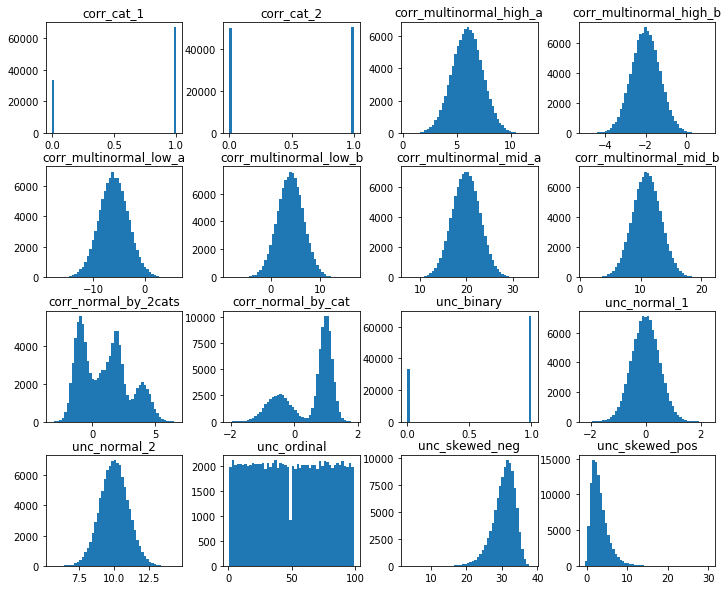

In [4]:
data.hist(bins=50, figsize=(12,10), grid=False)
plt.show()

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 18 columns):
unc_normal_1               100000 non-null float64
unc_normal_2               100000 non-null float64
unc_skewed_pos             100000 non-null float64
unc_skewed_neg             100000 non-null float64
unc_binary                 100000 non-null int64
unc_categories_5           100000 non-null object
unc_categories_100         100000 non-null object
unc_ordinal                100000 non-null int64
corr_cat_1                 100000 non-null int64
corr_cat_2                 100000 non-null int64
corr_normal_by_cat         100000 non-null float64
corr_normal_by_2cats       100000 non-null float64
corr_multinormal_high_a    100000 non-null float64
corr_multinormal_high_b    100000 non-null float64
corr_multinormal_mid_a     100000 non-null float64
corr_multinormal_mid_b     100000 non-null float64
corr_multinormal_low_a     100000 non-null float64
corr_multinormal_low_b     100000

In [6]:
data.describe(include='all').fillna('-')

,unc_normal_1,unc_normal_2,unc_skewed_pos,unc_skewed_neg,unc_binary,unc_categories_5,unc_categories_100,unc_ordinal,corr_cat_1,corr_cat_2,corr_normal_by_cat,corr_normal_by_2cats,corr_multinormal_high_a,corr_multinormal_high_b,corr_multinormal_mid_a,corr_multinormal_mid_b,corr_multinormal_low_a,corr_multinormal_low_b
count,100000,100000,100000,100000,100000,100000,100000,100000,100000,100000,100000,100000,100000,100000,100000,100000,100000,100000
unique,-,-,-,-,-,5,100,-,-,-,-,-,-,-,-,-,-,-
top,-,-,-,-,-,a,fao,-,-,-,-,-,-,-,-,-,-,-
freq,-,-,-,-,-,39976,1070,-,-,-,-,-,-,-,-,-,-,-
mean,-0.00353272,9.99797,3.15068,30.5588,0.66704,-,-,49.9657,0.66588,0.50123,0.498332,1.00963,6.00213,-1.99846,19.9884,11.0067,-5.99253,4.01254
std,0.500637,0.99882,2.21203,3.18565,0.471275,-,-,28.6357,0.471684,0.500001,0.761824,1.87658,1.41157,0.707012,2.99893,2.34064,2.83792,2.64487
min,-2.21133,5.55834,-0.529371,3.29279,0,-,-,1,0,0,-2.03729,-3.17371,0.42189,-5.00995,7.22584,0.7938,-17.993,-8.32804
25%,-0.34129,9.3227,1.61823,28.7694,0,-,-,25,0,0,-0.235731,-0.719836,5.04508,-2.4741,17.947,9.4343,-7.90702,2.22662
50%,-0.00250501,9.99955,2.66975,31.0192,1,-,-,50,1,1,0.863736,0.995326,6.00482,-1.99784,19.9879,11.0062,-6.00161,4.02698
75%,0.335074,10.669,4.13198,32.8388,1,-,-,75,1,1,1.06397,2.23844,6.94972,-1.52092,22.0107,12.5823,-4.07461,5.80069


In [7]:
data[[col for col in data.columns if 'corr_' in col]].corr()

,corr_cat_1,corr_cat_2,corr_normal_by_cat,corr_normal_by_2cats,corr_multinormal_high_a,corr_multinormal_high_b,corr_multinormal_mid_a,corr_multinormal_mid_b,corr_multinormal_low_a,corr_multinormal_low_b
corr_cat_1,1.000000,-0.008561,0.928559,-0.756343,0.002882,-0.005980,0.006337,0.005027,-0.002432,-0.002955
corr_cat_2,-0.008561,1.000000,-0.010041,-0.170186,0.000450,-0.001931,-0.001328,-0.000012,-0.001014,0.002072
corr_normal_by_cat,0.928559,-0.010041,1.000000,-0.701950,0.002613,-0.004975,0.006279,0.004743,-0.002571,-0.004781
corr_normal_by_2cats,-0.756343,-0.170186,-0.701950,1.000000,-0.001224,0.004205,0.000528,-0.002070,-0.000028,0.000977
corr_multinormal_high_a,0.002882,0.000450,0.002613,-0.001224,1.000000,-0.800776,0.001870,0.003020,-0.004733,0.001591
corr_multinormal_high_b,-0.005980,-0.001931,-0.004975,0.004205,-0.800776,1.000000,-0.001532,-0.006589,0.003324,-0.000115
corr_multinormal_mid_a,0.006337,-0.001328,0.006279,0.000528,0.001870,-0.001532,1.000000,0.303468,-0.142300,0.003123
corr_multinormal_mid_b,0.005027,-0.000012,0.004743,-0.002070,0.003020,-0.006589,0.303468,1.000000,-0.001540,-0.005495
corr_multinormal_low_a,-0.002432,-0.001014,-0.002571,-0.000028,-0.004733,0.003324,-0.142300,-0.001540,1.000000,0.159693
corr_multinormal_low_b,-0.002955,0.002072,-0.004781,0.000977,0.001591,-0.000115,0.003123,-0.005495,0.159693,1.000000


# Target variables creation

In [8]:
def linear_targets(data, tmp):
    df = data.copy()
    np.random.seed(23)
    entries = df.shape[0]
    
    coef_dict = {}
    
    # all
    coefs = [3, 0.4, -0.01, 0.03, -2.4, 0.11, 0.1, 6, 2.36, 7.3, 0.75, 0.69, -9.47, 0.73, 1.98, 4.61,
       -0.5, 3.8, 0.16, -0.4, -1]
    df['tar_lin_full'] = tmp.multiply(coefs, axis=1).sum(axis=1) + np.random.normal(0, 11, size=entries)
    coef_dict['tar_lin_full'] = pd.DataFrame({'feat': tmp.columns, 'coef': coefs})
    
    # all the uncorrelated
    coefs = [3, 0.4, -0.01, 0.03, -2.4, 0.11, 0.1, 6, 2.36, 7.3, 0.75]
    df['tar_lin_unc'] = (tmp[[col for col in tmp.columns if col.startswith('unc_')]].multiply(coefs, axis=1).sum(axis=1) + 
                         np.random.normal(1, 0.4, size=entries))
    coef_dict['tar_lin_unc'] = pd.DataFrame({'feat': [col for col in tmp.columns if col.startswith('unc_')], 'coef': coefs})
    
    # all the correlated
    coefs = [3, 0.4, -0.01, 0.03, -2.4, 0.11, 0.1, -6, 2.36, -0.8]
    df['tar_lin_corr'] = (tmp[[col for col in tmp.columns if col.startswith('corr_')]].multiply(coefs, axis=1).sum(axis=1) + 
                          np.random.normal(4, 3, size=entries))
    coef_dict['tar_lin_corr'] = pd.DataFrame({'feat': [col for col in tmp.columns if col.startswith('corr_')], 'coef': coefs})
    
    # 3 variables
    coefs = [0.4, -0.01, 0.03]
    df['tar_lin_3'] = (tmp[['unc_normal_1', 'corr_normal_by_cat', 'corr_multinormal_mid_a']].multiply(coefs, axis=1).sum(axis=1) + 
                       np.random.normal(-0.7, 1, size=entries))
    coef_dict['tar_lin_3'] = pd.DataFrame({'feat': ['unc_normal_1', 'corr_normal_by_cat', 'corr_multinormal_mid_a'], 'coef': coefs})
    
    # 3 variables and interactions
    coefs = [0.4, -0.01, 0.03]
    df['tar_lin_3int'] = (tmp[['unc_normal_1', 'corr_normal_by_cat', 'corr_multinormal_mid_a']].multiply(coefs, axis=1).sum(axis=1) + 
                          0.6 * tmp['unc_normal_1'] * tmp['corr_normal_by_cat'] -
                          1.3 * tmp['corr_normal_by_cat'] * tmp['unc_normal_1'] * tmp['corr_normal_by_cat'] + 
                          np.random.normal(-0.7, 1, size=entries))
    coef_dict['tar_lin_3int'] = pd.DataFrame({'feat': ['unc_normal_1', 'corr_normal_by_cat', 'corr_multinormal_mid_a', 
                                                       'unc_normal_1__corr_normal_by_cat', 'all_3'], 
                                              'coef': coefs + [0.6, 1.3]})
    
    return df, coef_dict


def nonlinear_targets(data, tmp):
    df = data.copy()
    np.random.seed(23)
    entries = df.shape[0]
    
    coef_dict = {}
    
    # all
    coefs = [3, 0.4, 0.01, 0.03, 2.4, 0.11, 0.1, 6, 2.36, 7.3, 0.75, 0.69, 9.47, 0.73, 1.98, 4.61,
       0.5, 3.8, 0.16, 0.4, 1]
    df['tar_nonlin_full'] = 0.5*np.expm1(-tmp.multiply(coefs, axis=1).sum(axis=1) / 100) + np.random.normal(2, 2, size=entries)
    coef_dict['tar_nonlin_full'] = pd.DataFrame({'feat': tmp.columns, 'coef': coefs})
    
    # all the uncorrelated
    coefs = [3, 0.4, -0.01, 0.03, -2.4, 0.11, 0.1, 6, 2.36, 7.3, 0.75]
    df['tar_nonlin_unc'] = (np.expm1(tmp[[col for col in tmp.columns 
                                         if col.startswith('unc_')]].multiply(coefs, axis=1).sum(axis=1) / 20) + 
                            np.random.normal(0, 10, size=entries))
    coef_dict['tar_nonlin_unc'] = pd.DataFrame({'feat': [col for col in tmp.columns if col.startswith('unc_')], 'coef': coefs})
    
    # all the correlated
    coefs = [3, 0.4, -0.01, 0.03, -2.4, 0.11, 0.1, -6, 2.36, -0.8]
    df['tar_nonlin_corr'] = (np.expm1(tmp[[col for col in tmp.columns 
                                          if col.startswith('corr_')]].multiply(coefs, axis=1).sum(axis=1) / 20) + 
                             np.random.normal(4, 2, size=entries))
    coef_dict['tar_nonlin_corr'] = pd.DataFrame({'feat': [col for col in tmp.columns if col.startswith('corr_')], 'coef': coefs})
    
    # 3 variables
    df['tar_nonlin_3'] = (0.04*tmp['unc_ordinal']**2 - 0.09*tmp['corr_normal_by_cat'] + 0.8*np.tanh(tmp['corr_multinormal_mid_a']) + 
                          np.random.normal(-0.7, 10, size=entries))
    coef_dict['tar_nonlin_3'] = pd.DataFrame({'feat': ['unc_normal_1_squared', 'corr_normal_by_cat', 'corr_multinormal_mid_a_tanh'], 
                                           'coef': [0.04, -0.09, 0.8]})
    
    # 3 variables and interactions
    df['tar_nonlin_3int'] = (0.04*tmp['unc_ordinal']**2 - 0.09*tmp['corr_normal_by_cat'] - 0.8*np.tanh(tmp['corr_multinormal_mid_a']) + 
                          0.6 * tmp['unc_normal_1'] * tmp['corr_normal_by_cat'] -
                          0.3 * tmp['corr_normal_by_cat'] * tmp['unc_normal_1'] * tmp['corr_normal_by_cat'] + 
                          np.random.normal(-0.7, 10, size=entries))
    coef_dict['tar_nonlin_3int'] = pd.DataFrame({'feat': ['unc_normal_1_squared', 'corr_normal_by_cat', 'corr_multinormal_mid_a_tanh', 
                                                          'unc_normal_1__corr_normal_by_cat', 'all_3'], 
                                           'coef': [0.04, -0.09, 0.8, 0.6, -0.3]})
    
    return df, coef_dict


def make_targets(data):
    tmp = data.copy()
    tmp['unc_categories_100'] = tmp.unc_categories_100.astype('category').cat.codes.astype(int)
    tmp = pd.get_dummies(tmp, drop_first=True)
    
    df, coef_lin = linear_targets(data, tmp)
    df, coef_nonlin = nonlinear_targets(df, tmp)

    return df, coef_lin, coef_nonlin

In [9]:
data, coefs_linear, coefs_nonlinear = make_targets(data)

data.head()

,unc_normal_1,unc_normal_2,unc_skewed_pos,unc_skewed_neg,unc_binary,unc_categories_5,unc_categories_100,unc_ordinal,corr_cat_1,corr_cat_2,corr_normal_by_cat,corr_normal_by_2cats,corr_multinormal_high_a,corr_multinormal_high_b,corr_multinormal_mid_a,corr_multinormal_mid_b,corr_multinormal_low_a,corr_multinormal_low_b,tar_lin_full,tar_lin_unc,tar_lin_corr,tar_lin_3,tar_lin_3int,tar_nonlin_full,tar_nonlin_unc,tar_nonlin_corr,tar_nonlin_3,tar_nonlin_3int
0,0.333494,9.046767,2.098417,29.620455,0,b,ljr,7,1,0,0.541971,0.351782,8.430675,-3.355695,27.159674,10.704274,-5.322705,7.330677,83.127530,17.975525,-94.548065,0.682160,0.060012,3.244956,-8.150569,2.331188,6.405137,-1.148288
1,0.012907,10.954762,2.895381,29.842289,1,a,vah,22,1,1,0.857349,-0.629935,3.334968,-0.792505,21.696217,11.128385,-6.570617,2.406493,44.611882,15.378844,-82.392359,0.321245,-0.970262,1.898439,10.561064,3.252234,23.120533,8.666193
2,-0.388810,9.986689,3.343133,29.393639,0,d,slv,81,1,0,1.244200,2.232988,3.895617,-1.586941,22.708020,10.537641,-4.403688,5.108706,59.912546,28.101300,-76.892632,0.318452,0.621707,0.265541,2.744933,3.691036,267.479799,263.880632
3,0.474317,10.710674,3.307999,28.968660,1,d,exm,95,0,1,0.092622,3.870697,8.248896,-3.246644,22.010211,9.388242,-7.545897,2.646304,66.691221,24.317470,-88.730236,0.774157,-0.322802,3.882116,9.270183,3.651130,367.342161,354.587015
4,0.350836,9.140127,1.827119,28.887216,0,d,jgc,29,0,1,-0.230801,4.352840,4.496770,-1.173505,17.417453,6.868044,-7.087807,4.464484,29.737370,20.812954,-67.718221,0.612704,1.681971,3.378512,-6.859040,1.986998,40.236153,50.003422


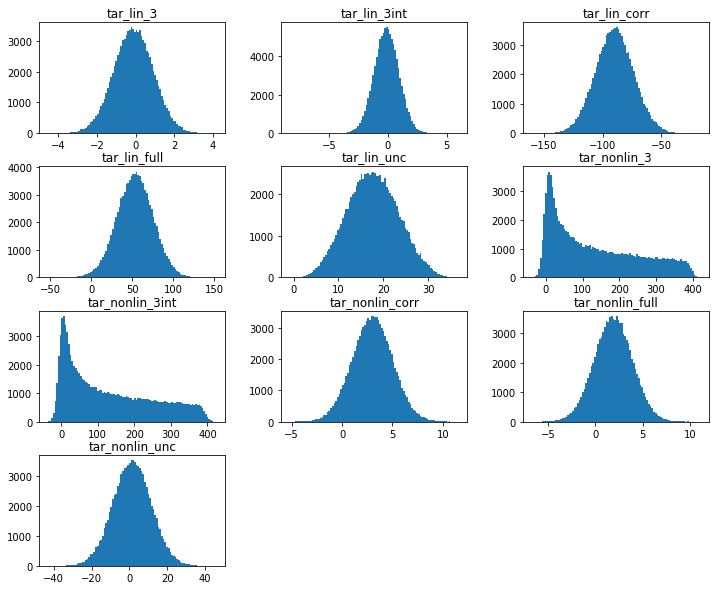

In [10]:
data[[col for col in data.columns if 'tar_' in col]].hist(bins=100, figsize=(12,10), grid=False)
plt.show()

In [11]:
data.to_csv('data/simulated/clean.csv', index=False)

In [12]:
coefs_total = z = {**coefs_linear, **coefs_nonlinear}

with open('data/simulated/coefficients.pkl', 'wb') as f:
    pickle.dump(coefs_total, f)

# Making dirty data

In [13]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 28 columns):
unc_normal_1               100000 non-null float64
unc_normal_2               100000 non-null float64
unc_skewed_pos             100000 non-null float64
unc_skewed_neg             100000 non-null float64
unc_binary                 100000 non-null int64
unc_categories_5           100000 non-null object
unc_categories_100         100000 non-null object
unc_ordinal                100000 non-null int64
corr_cat_1                 100000 non-null int64
corr_cat_2                 100000 non-null int64
corr_normal_by_cat         100000 non-null float64
corr_normal_by_2cats       100000 non-null float64
corr_multinormal_high_a    100000 non-null float64
corr_multinormal_high_b    100000 non-null float64
corr_multinormal_mid_a     100000 non-null float64
corr_multinormal_mid_b     100000 non-null float64
corr_multinormal_low_a     100000 non-null float64
corr_multinormal_low_b     100000

In [14]:
def dirtify(data):
    # do not add missing values to the targets
    df = data[[col for col in data.columns if 'tar_' not in col]].copy()
    n_entries = df.shape[0]
    np.random.seed(23)
    
    # adding random noise to some columns
    df['unc_normal_1'] += np.random.normal(loc=0, scale=15, size=n_entries) / 10
    df['corr_normal_by_cat'] += np.random.normal(loc=-0.5, scale=5, size=n_entries) / 10
    df['unc_skewed_neg'] += np.random.normal(loc=0, scale=50, size=n_entries) / 10
    
    
    # make outliers
    random_entries = np.random.random(df.shape[0])<0.00001
    df['unc_normal_2'] = df['unc_normal_2'].mask(random_entries).fillna(df['unc_normal_2'] + 20)
    random_entries = np.random.random(df.shape[0])<0.00001
    df['corr_multinormal_mid_a'] = df['corr_multinormal_mid_a'].mask(random_entries).fillna(df['corr_multinormal_mid_a'] - 54)
    
    # adding 0.5% missing values
    missing = np.random.random(df.shape)<0.005
    df = df.mask(missing)
    
    # putting the targets back
    df = df.join(data[[col for col in data.columns if 'tar_' in col]])
    
    return df

In [15]:
data_dirty = dirtify(data)

data_dirty.head()

,unc_normal_1,unc_normal_2,unc_skewed_pos,unc_skewed_neg,unc_binary,unc_categories_5,unc_categories_100,unc_ordinal,corr_cat_1,corr_cat_2,corr_normal_by_cat,corr_normal_by_2cats,corr_multinormal_high_a,corr_multinormal_high_b,corr_multinormal_mid_a,corr_multinormal_mid_b,corr_multinormal_low_a,corr_multinormal_low_b,tar_lin_full,tar_lin_unc,tar_lin_corr,tar_lin_3,tar_lin_3int,tar_nonlin_full,tar_nonlin_unc,tar_nonlin_corr,tar_nonlin_3,tar_nonlin_3int
0,1.333976,9.046767,2.098417,27.929369,0.0,b,ljr,7.0,1.0,0.0,0.015355,0.351782,8.430675,-3.355695,27.159674,10.704274,-5.322705,7.330677,83.127530,17.975525,-94.548065,0.682160,0.060012,3.244956,-8.150569,2.331188,6.405137,-1.148288
1,0.051626,10.954762,2.895381,30.440204,1.0,a,vah,22.0,1.0,1.0,1.284730,-0.629935,3.334968,-0.792505,21.696217,11.128385,-6.570617,2.406493,44.611882,15.378844,-82.392359,0.321245,-0.970262,1.898439,10.561064,3.252234,23.120533,8.666193
2,-1.555239,9.986689,3.343133,31.079598,0.0,d,slv,81.0,1.0,0.0,1.187544,NaN,3.895617,-1.586941,22.708020,10.537641,-4.403688,5.108706,59.912546,28.101300,-76.892632,0.318452,0.621707,0.265541,2.744933,3.691036,267.479799,263.880632
3,1.897268,10.710674,3.307999,30.573395,1.0,d,exm,95.0,0.0,1.0,0.397959,3.870697,8.248896,-3.246644,22.010211,9.388242,-7.545897,2.646304,66.691221,24.317470,-88.730236,0.774157,-0.322802,3.882116,9.270183,3.651130,367.342161,354.587015
4,1.403344,9.140127,1.827119,26.279796,0.0,d,jgc,29.0,0.0,1.0,-0.710738,4.352840,4.496770,-1.173505,17.417453,6.868044,-7.087807,4.464484,29.737370,20.812954,-67.718221,0.612704,1.681971,3.378512,-6.859040,1.986998,40.236153,50.003422


In [16]:
data_dirty.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 28 columns):
unc_normal_1               99532 non-null float64
unc_normal_2               99517 non-null float64
unc_skewed_pos             99475 non-null float64
unc_skewed_neg             99514 non-null float64
unc_binary                 99487 non-null float64
unc_categories_5           99509 non-null object
unc_categories_100         99512 non-null object
unc_ordinal                99485 non-null float64
corr_cat_1                 99480 non-null float64
corr_cat_2                 99497 non-null float64
corr_normal_by_cat         99499 non-null float64
corr_normal_by_2cats       99507 non-null float64
corr_multinormal_high_a    99500 non-null float64
corr_multinormal_high_b    99494 non-null float64
corr_multinormal_mid_a     99539 non-null float64
corr_multinormal_mid_b     99493 non-null float64
corr_multinormal_low_a     99494 non-null float64
corr_multinormal_low_b     99498 non-null 

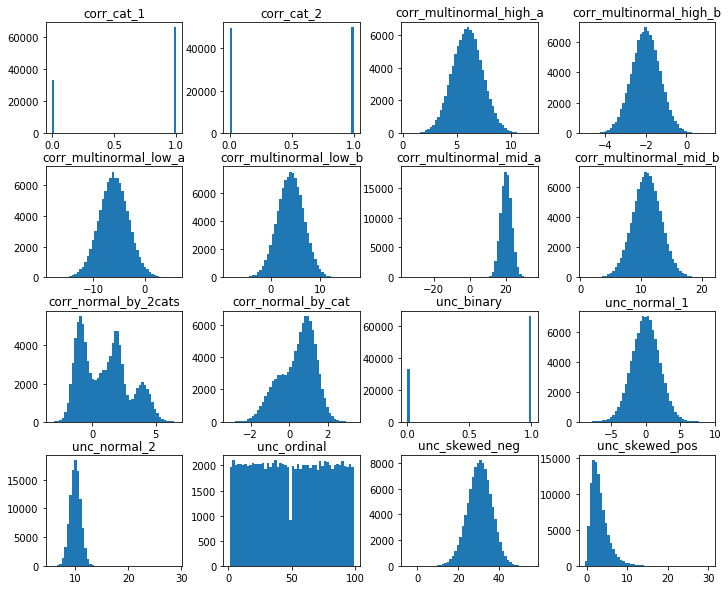

In [17]:
data_dirty[[col for col in data_dirty.columns if 'tar_' not in col]].hist(bins=50, figsize=(12,10), grid=False)
plt.show()

In [18]:
data_dirty.to_csv('data/simulated/dirty.csv', index=False)

# Sklearn datasets

Sklearn gives the possibility of generating datasets suitable for regression with target generated by linear functions. For example, this is a dataframe with 4 variables that all generate the target with no noise

   coefficient variable
0    49.556050        a
1    59.150720        b
2    56.559536        c
3    72.210570        d
               a         b         c         d    target
a       1.000000 -0.165457  0.030217  0.124663  0.409325
b      -0.165457  1.000000 -0.091360  0.018547  0.396926
c       0.030217 -0.091360  1.000000  0.063502  0.450172
d       0.124663  0.018547  0.063502  1.000000  0.709363
target  0.409325  0.396926  0.450172  0.709363  1.000000


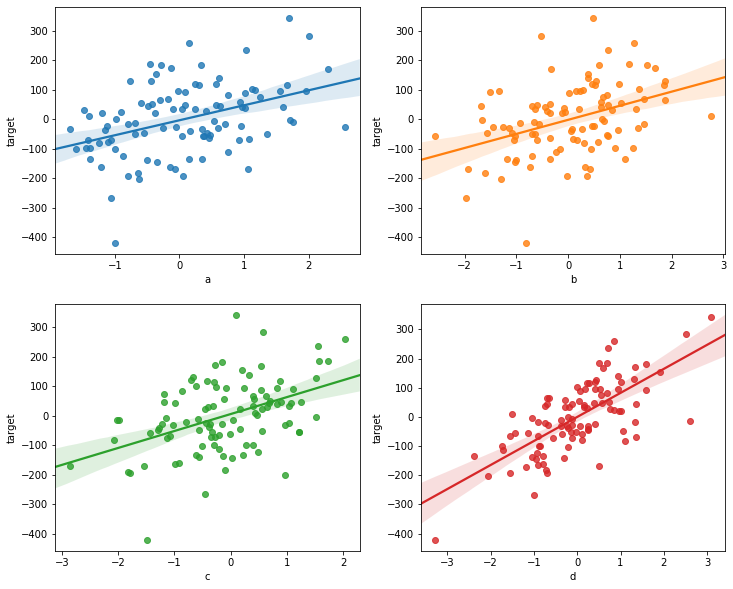

In [39]:
data_sim, target, coefficients = make_regression(n_samples=100, n_features=4, n_informative=4, coef=True, random_state=21, noise=0)

data_sim = pd.DataFrame(data_sim, columns=['a', 'b', 'c', 'd'])
data_sim['target'] = target

coeff = pd.DataFrame(coefficients, columns=['coefficient'])
coeff['variable'] = ['a', 'b', 'c', 'd']

print(coeff)

exp.corr_target(data_sim, 'target', ['a', 'b', 'c', 'd'])

While adding noise would create the following

   coefficient variable
0    49.556050        a
1    72.210570        b
2    56.559536        c
3    59.150720        d
               a         b         c         d    target
a       1.000000  0.124663  0.030217 -0.165457  0.425259
b       0.124663  1.000000  0.063502  0.018547  0.520862
c       0.030217  0.063502  1.000000 -0.091360  0.324699
d      -0.165457  0.018547 -0.091360  1.000000  0.326914
target  0.425259  0.520862  0.324699  0.326914  1.000000


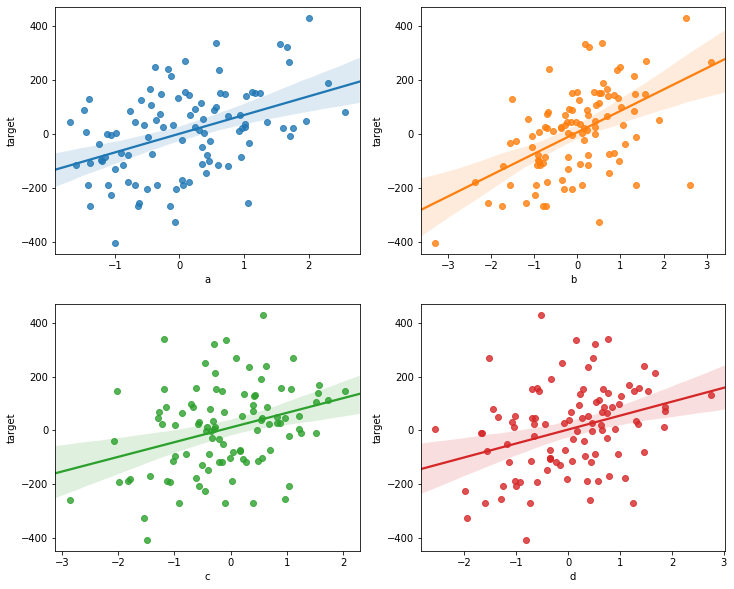

In [42]:
data_sim, target, coefficients = make_regression(n_samples=100, n_features=4, n_informative=4, coef=True, random_state=21, noise=100)

data_sim = pd.DataFrame(data_sim, columns=['a', 'b', 'c', 'd'])
data_sim['target'] = target

coeff = pd.DataFrame(coefficients, columns=['coefficient'])
coeff['variable'] = ['a', 'b', 'c', 'd']

print(coeff)

exp.corr_target(data_sim, 'target', ['a', 'b', 'c', 'd'])

If we want the data to be generated by fewer features, we can achieve it by changing `n_informative`

   coefficient variable
0      0.00000        a
1     49.55605        b
2      0.00000        c
3     72.21057        d
               a         b         c         d    target
a       1.000000  0.030217 -0.091360  0.063502  0.066112
b       0.030217  1.000000 -0.165457  0.124663  0.611663
c      -0.091360 -0.165457  1.000000  0.018547 -0.069970
d       0.063502  0.124663  0.018547  1.000000  0.861198
target  0.066112  0.611663 -0.069970  0.861198  1.000000


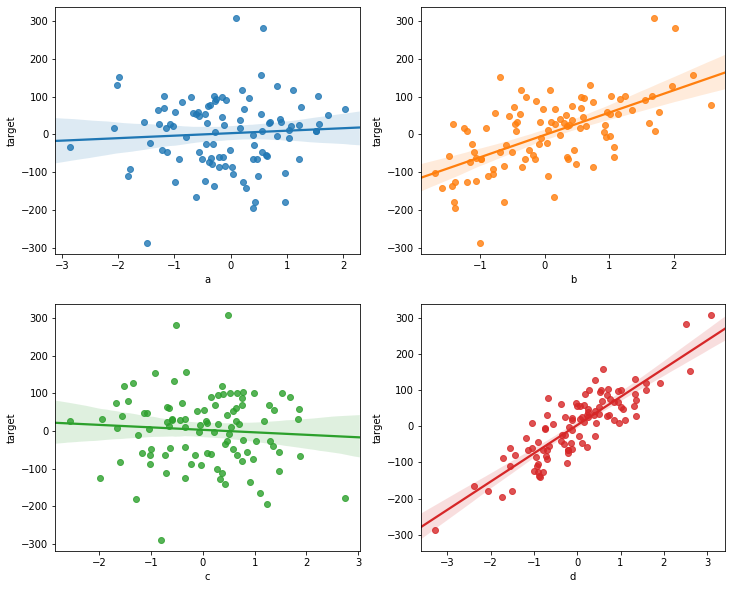

In [43]:
data_sim, target, coefficients = make_regression(n_samples=100, n_features=4, n_informative=2, coef=True, random_state=21, noise=0)

data_sim = pd.DataFrame(data_sim, columns=['a', 'b', 'c', 'd'])
data_sim['target'] = target

coeff = pd.DataFrame(coefficients, columns=['coefficient'])
coeff['variable'] = ['a', 'b', 'c', 'd']

print(coeff)

exp.corr_target(data_sim, 'target', ['a', 'b', 'c', 'd'])

While to simulate a more realistic situation we can play with `effective_rank` 

   coefficient variable
0    79.028462        a
1     5.402325        b
2    55.953174        c
3    50.533446        d
               a         b         c         d    target
a       1.000000  0.037888 -0.311096  0.249183  0.772151
b       0.037888  1.000000  0.221020 -0.239929  0.085003
c      -0.311096  0.221020  1.000000 -0.271181  0.170430
d       0.249183 -0.239929 -0.271181  1.000000  0.542918
target  0.772151  0.085003  0.170430  0.542918  1.000000


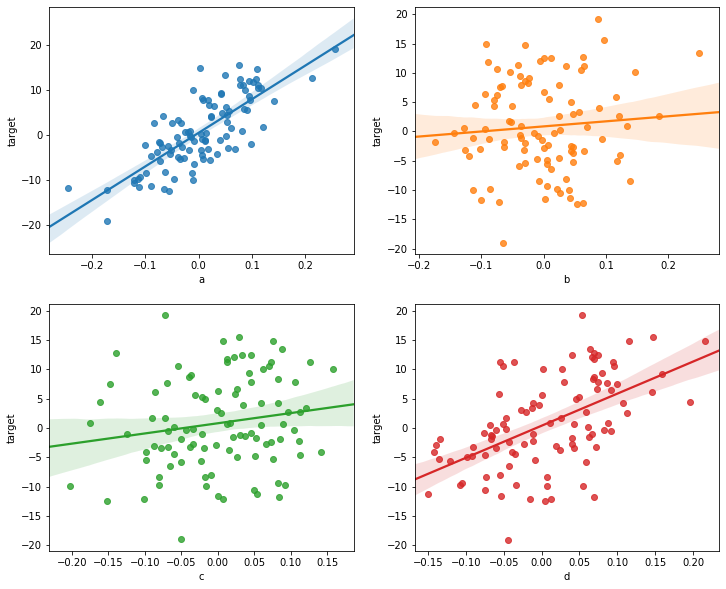

In [55]:
data_sim, target, coefficients = make_regression(n_samples=100, 
                                                 n_features=4, n_informative=4, 
                                                 effective_rank=1, tail_strength=0.8,
                                                 coef=True, random_state=21, noise=0)

data_sim = pd.DataFrame(data_sim, columns=['a', 'b', 'c', 'd'])
data_sim['target'] = target

coeff = pd.DataFrame(coefficients, columns=['coefficient'])
coeff['variable'] = ['a', 'b', 'c', 'd']

print(coeff)

exp.corr_target(data_sim, 'target', ['a', 'b', 'c', 'd'])

We can now create a better function to handle all this.

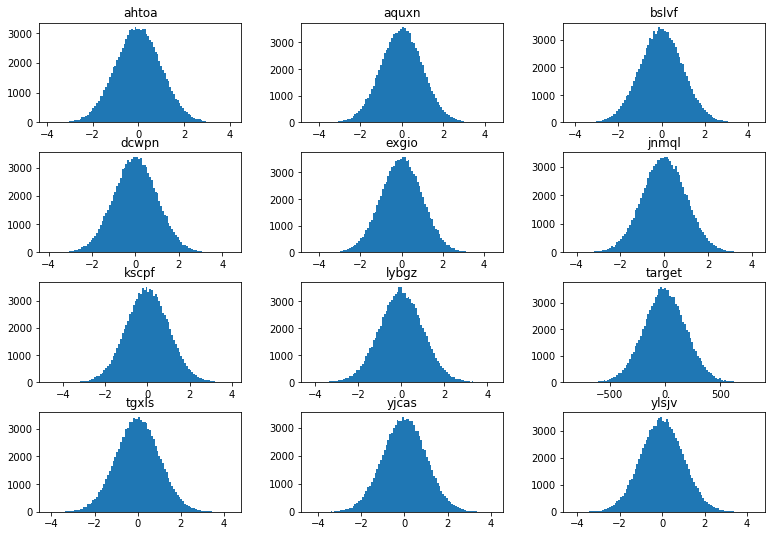

In [60]:
def make_data_regression(n_features, n_informative, noise, effective_rank=None, tail_stregth=0.5):
    data_sim, target, coefficients = make_regression(n_samples=100000, 
                                                 n_features=n_features, n_informative=n_informative, 
                                                 effective_rank=effective_rank, tail_strength=tail_stregth,
                                                 coef=True, random_state=21, noise=noise)
    
    random.seed(23)
    i = 0
    random_names = []
    # generate n_features random strings of 5 characters
    while i < n_features:
        random_names.append(''.join([random.choice(string.ascii_lowercase) for _ in range(5)]))
        i += 1
    
    data_sim = pd.DataFrame(data_sim, columns=random_names)
    data_sim['target'] = target

    coeff = pd.DataFrame({'variable': random_names, 'coefficient': coefficients})
    
    return data_sim, coeff

data_sim, coeff = make_data_regression(11, 11, 0)

data_sim.hist(bins=100, figsize=(13, 9), grid=False)
plt.show()

   variable  coefficient
0     yjcas    60.997032
1     jnmql     4.032212
2     exgio    41.031434
3     ahtoa    35.202247
4     dcwpn    73.137752
5     aquxn    50.407255
6     lybgz     3.263851
7     bslvf    87.278816
8     tgxls    58.465952
9     ylsjv    99.033243
10    kscpf    20.940859
           yjcas     jnmql     exgio     ahtoa     dcwpn     aquxn     lybgz  \
yjcas   1.000000 -0.008356 -0.001930  0.008785 -0.001568 -0.000295 -0.005339   
jnmql  -0.008356  1.000000 -0.003116  0.000220  0.001999  0.005270 -0.001451   
exgio  -0.001930 -0.003116  1.000000 -0.002098 -0.006541 -0.000739  0.004448   
ahtoa   0.008785  0.000220 -0.002098  1.000000 -0.004450 -0.000602 -0.000868   
dcwpn  -0.001568  0.001999 -0.006541 -0.004450  1.000000  0.002326  0.001398   
aquxn  -0.000295  0.005270 -0.000739 -0.000602  0.002326  1.000000 -0.000894   
lybgz  -0.005339 -0.001451  0.004448 -0.000868  0.001398 -0.000894  1.000000   
bslvf   0.001209  0.003597 -0.002456  0.000650 -0.000137 -0.

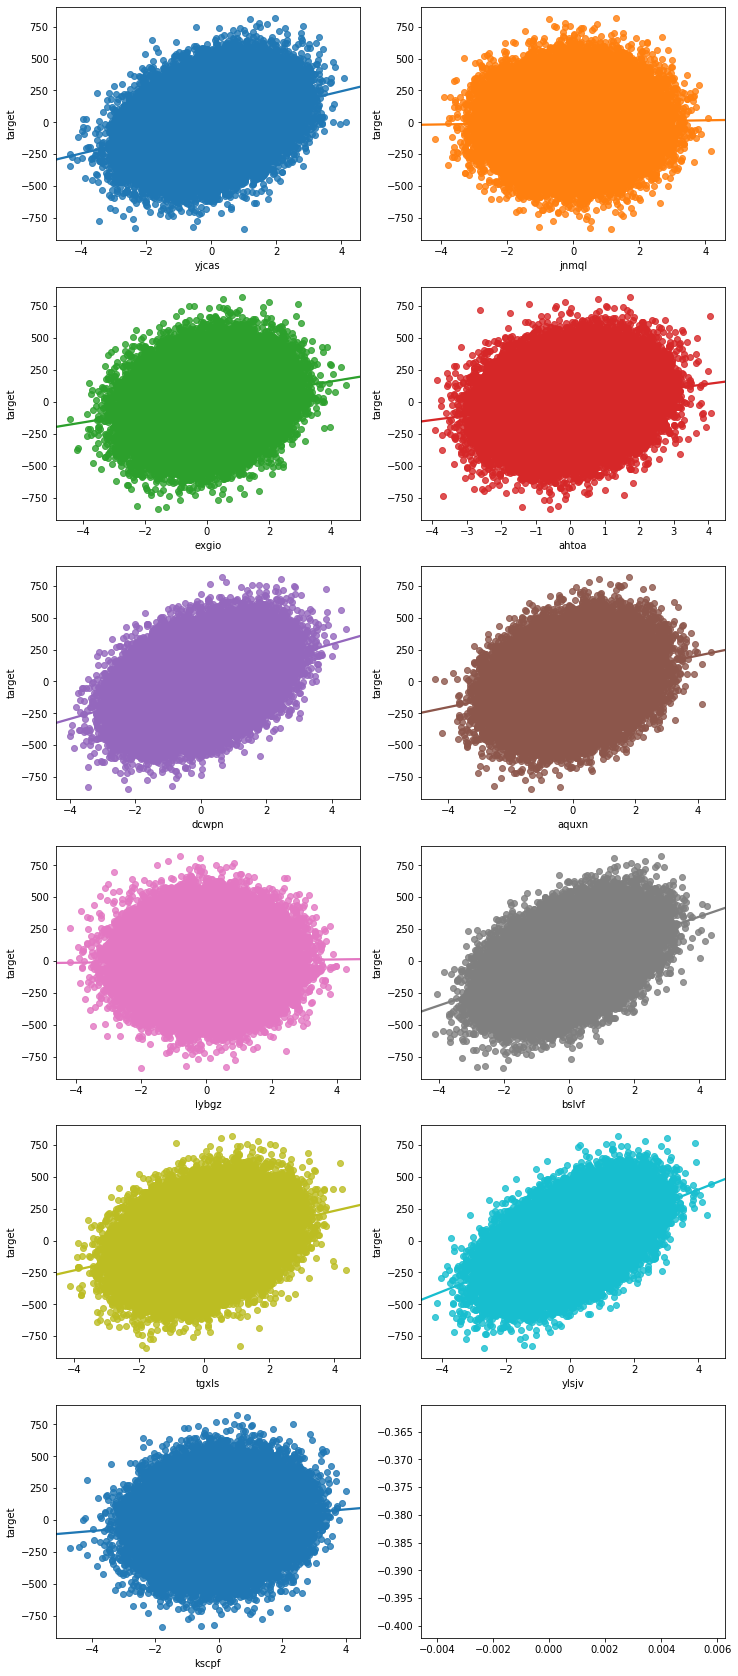

In [61]:
print(coeff)

exp.corr_target(data_sim, 'target', [col for col in data_sim.columns if 'target' not in col])

It is time to generate a bunch of these for our experiments

In [72]:
# 10 features, all used, no noise
data_sim, coeff = make_data_regression(10, 10, 0)
data_sim.to_csv('data/simulated/10_feat_10_inf_nonoise.csv', index=False)
coeff.to_csv('data/simulated/10_feat_10_inf_nonoise__coefficients.csv', index=False)

In [73]:
# 10 features, all used, with noise
data_sim, coeff = make_data_regression(10, 10, 200)
data_sim.to_csv('data/simulated/10_feat_10_inf_noise.csv', index=False)
coeff.to_csv('data/simulated/10_feat_10_inf_noise__coefficients.csv', index=False)

In [77]:
# 100 features, 65 used, with noise
data_sim, coeff = make_data_regression(100, 65, 450)
data_sim.to_csv('data/simulated/100_feat_65_inf_noise.csv', index=False)
coeff.to_csv('data/simulated/100_feat_65_inf_noise__coefficients.csv', index=False)

In [81]:
# 100 features, 5 used, with noise
data_sim, coeff = make_data_regression(100, 5, 150)
data_sim.to_csv('data/simulated/100_feat_5_inf_noise.csv', index=False)
coeff.to_csv('data/simulated/100_feat_5_inf_noise__coefficients.csv', index=False)

In [97]:
# 100 features, 100 used, with noise, rank
data_sim, coeff = make_data_regression(100, 100, 1, effective_rank=25, tail_stregth=0.8)
data_sim.to_csv('data/simulated/100_feat_100_inf_noise_rank.csv', index=False)
coeff.to_csv('data/simulated/100_feat_100_inf_noise_rank__coefficients.csv', index=False)

In [98]:
# 100 features, 65 used, with noise, rank
data_sim, coeff = make_data_regression(100, 65, 0.8, effective_rank=20, tail_stregth=0.8)
data_sim.to_csv('data/simulated/100_feat_65_inf_noise_rank.csv', index=False)
coeff.to_csv('data/simulated/100_feat_65_inf_noise_rank__coefficients.csv', index=False)

In [102]:
# 100 features, 50 used, very noise, rank
data_sim, coeff = make_data_regression(100, 50, 10, effective_rank=40, tail_stregth=0.8)
data_sim.to_csv('data/simulated/100_feat_50_inf_verynoise_rank.csv', index=False)
coeff.to_csv('data/simulated/100_feat_50_inf_verynoise_rank__coefficients.csv', index=False)

# Exploration

Just focusing on the simplest targets for brevity

## Linear relations with and without interactions

In [120]:
coefs_linear['tar_lin_3']

,feat,coef
0,unc_normal_1,0.40
1,corr_normal_by_cat,-0.01
2,corr_multinormal_mid_a,0.03


tar_lin_3                  1.000000
unc_skewed_neg            -0.955121
unc_normal_1               0.194833
tar_nonlin_full            0.194818
tar_lin_full               0.109601
corr_multinormal_mid_a     0.088228
tar_nonlin_3               0.083134
tar_lin_unc                0.035028
tar_lin_3int              -0.026398
tar_lin_corr              -0.024577
corr_multinormal_mid_b     0.021961
corr_multinormal_low_a    -0.016256
corr_normal_by_2cats       0.006700
tar_nonlin_unc             0.006696
corr_normal_by_cat        -0.004668
corr_cat_2                -0.004646
unc_normal_2               0.004390
corr_cat_1                -0.003530
unc_skewed_pos             0.002096
corr_multinormal_high_a    0.002070
unc_binary                 0.002044
corr_multinormal_high_b   -0.001801
tar_nonlin_3int            0.001285
tar_nonlin_corr            0.001208
corr_multinormal_low_b    -0.000565
unc_ordinal               -0.000099
Name: tar_lin_3, dtype: float64

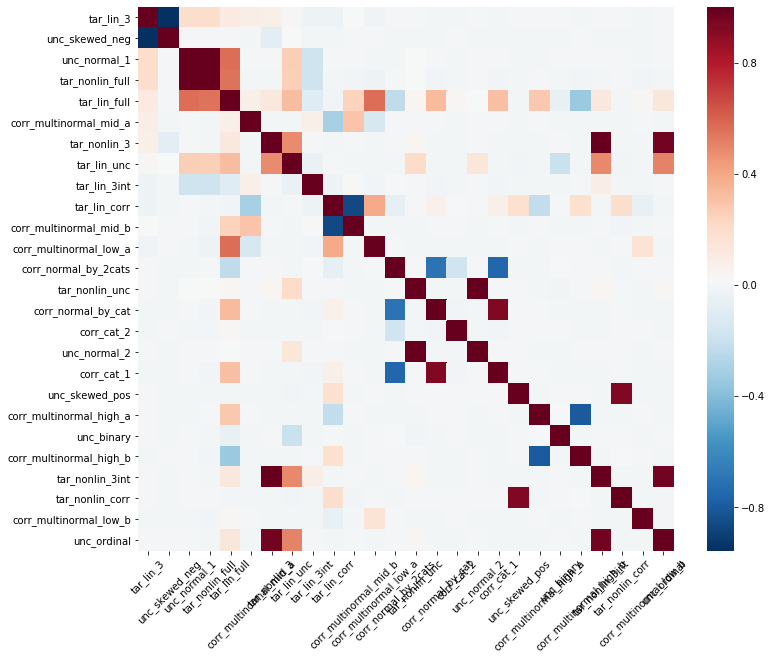

In [121]:
exp.plot_correlations(data, target='tar_lin_3')

                        unc_skewed_neg  unc_normal_1  corr_normal_by_cat  \
unc_skewed_neg                1.000000      0.001310           -0.001944   
unc_normal_1                  0.001310      1.000000            0.001915   
corr_normal_by_cat           -0.001944      0.001915            1.000000   
corr_multinormal_mid_a       -0.001556      0.001232            0.006279   
tar_lin_3                    -0.955121      0.194833           -0.004668   

                        corr_multinormal_mid_a  tar_lin_3  
unc_skewed_neg                       -0.001556  -0.955121  
unc_normal_1                          0.001232   0.194833  
corr_normal_by_cat                    0.006279  -0.004668  
corr_multinormal_mid_a                1.000000   0.088228  
tar_lin_3                             0.088228   1.000000  


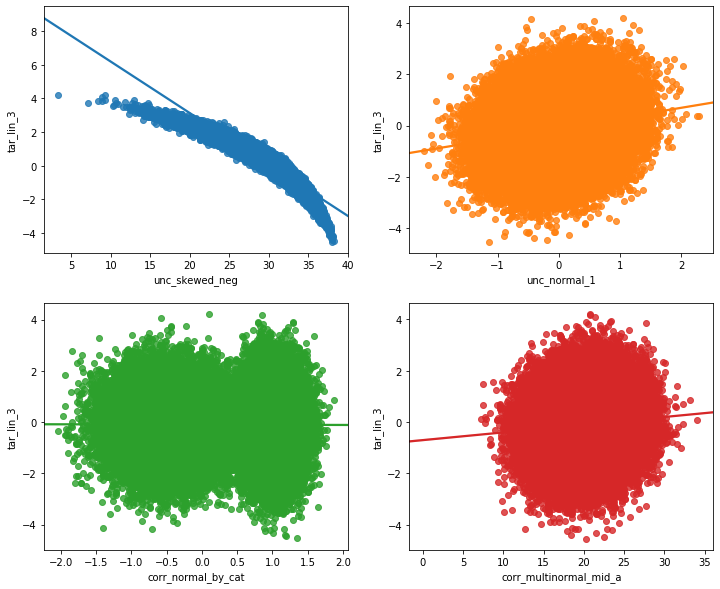

In [122]:
exp.corr_target(data, 'tar_lin_3', ['unc_skewed_neg', 'unc_normal_1', 'corr_normal_by_cat', 'corr_multinormal_mid_a'])

It is interesting to notice how `unc_skewed_neg` was not used to generate the target, it is completely uncorrelated with the features that generate the target, but it is so correlated with it. It will be even more interesting to check what happens when our ML models will focus on this feature rather than the truly important ones.

In [123]:
coefs_linear['tar_lin_3int']

,feat,coef
0,unc_normal_1,0.40
1,corr_normal_by_cat,-0.01
2,corr_multinormal_mid_a,0.03
3,unc_normal_1__corr_normal_by_cat,0.60
4,all_3,1.30


tar_lin_3int               1.000000
tar_nonlin_full           -0.178848
unc_normal_1              -0.178806
tar_lin_full              -0.097491
tar_nonlin_3int            0.084746
corr_multinormal_mid_a     0.082770
tar_lin_unc               -0.042918
tar_lin_corr              -0.029668
corr_multinormal_mid_b     0.029104
tar_lin_3                 -0.026398
corr_multinormal_low_a    -0.013169
corr_normal_by_2cats       0.010701
corr_normal_by_cat        -0.008795
corr_cat_1                -0.008338
corr_cat_2                -0.006148
tar_nonlin_3               0.005389
unc_normal_2               0.005061
unc_ordinal                0.004570
unc_skewed_pos            -0.004258
tar_nonlin_corr           -0.004099
corr_multinormal_high_a   -0.003889
tar_nonlin_unc             0.002117
unc_skewed_neg            -0.001284
corr_multinormal_low_b    -0.001121
unc_binary                -0.000785
corr_multinormal_high_b   -0.000075
Name: tar_lin_3int, dtype: float64

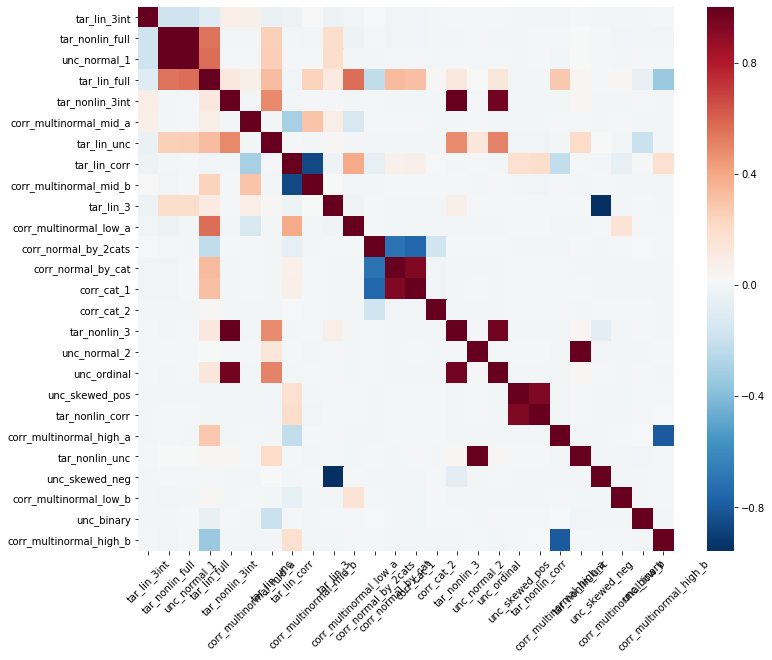

In [124]:
exp.plot_correlations(data, target='tar_lin_3int')

                        unc_normal_1  corr_normal_by_cat  \
unc_normal_1                1.000000            0.001915   
corr_normal_by_cat          0.001915            1.000000   
corr_multinormal_mid_a      0.001232            0.006279   
corr_multinormal_mid_b      0.001184            0.004743   
tar_lin_3int               -0.178806           -0.008795   

                        corr_multinormal_mid_a  corr_multinormal_mid_b  \
unc_normal_1                          0.001232                0.001184   
corr_normal_by_cat                    0.006279                0.004743   
corr_multinormal_mid_a                1.000000                0.303468   
corr_multinormal_mid_b                0.303468                1.000000   
tar_lin_3int                          0.082770                0.029104   

                        tar_lin_3int  
unc_normal_1               -0.178806  
corr_normal_by_cat         -0.008795  
corr_multinormal_mid_a      0.082770  
corr_multinormal_mid_b      0.029104  

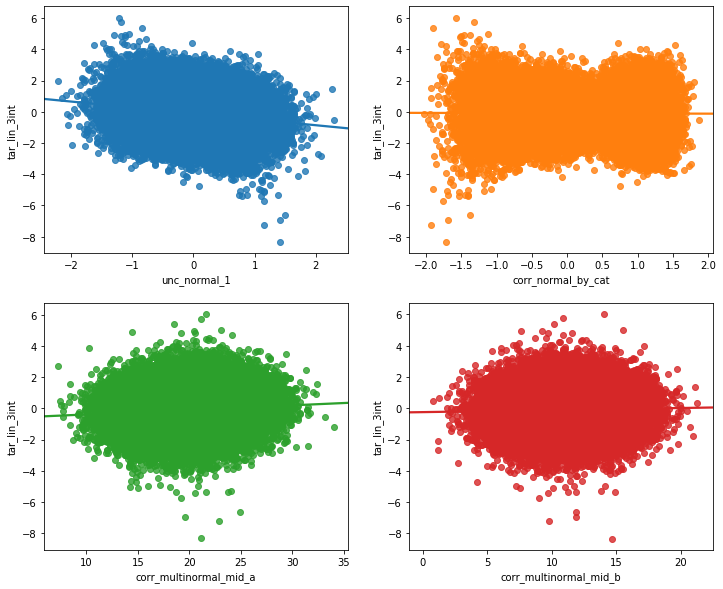

In [125]:
exp.corr_target(data, 'tar_lin_3int', ['unc_normal_1', 'corr_normal_by_cat', 'corr_multinormal_mid_a', 'corr_multinormal_mid_b'])

With the interactions, we lose the accidental correlation with a random variable and we are left with the more predictable situation: the 3 generating features and the one correlated with one of them.

## Non-linear relation with and without interactions

In [126]:
coefs_nonlinear['tar_nonlin_3']

,feat,coef
0,unc_normal_1_squared,0.04
1,corr_normal_by_cat,-0.09
2,corr_multinormal_mid_a_tanh,0.80


tar_nonlin_3               1.000000
tar_nonlin_3int            0.992937
unc_ordinal                0.965494
tar_lin_unc                0.487517
tar_lin_full               0.124164
unc_skewed_neg            -0.083847
tar_lin_3                  0.083134
tar_nonlin_unc             0.038093
tar_lin_3int               0.005389
corr_cat_2                -0.005061
unc_normal_2               0.004868
corr_normal_by_cat        -0.004434
tar_nonlin_corr           -0.004413
corr_multinormal_low_b    -0.004373
corr_multinormal_mid_a    -0.003848
corr_multinormal_high_b   -0.003672
tar_nonlin_full           -0.003610
corr_multinormal_low_a    -0.003510
unc_binary                 0.003210
unc_skewed_pos            -0.003207
corr_normal_by_2cats       0.003192
corr_cat_1                -0.003185
tar_lin_corr              -0.002421
corr_multinormal_high_a   -0.001927
unc_normal_1               0.001677
corr_multinormal_mid_b     0.000825
Name: tar_nonlin_3, dtype: float64

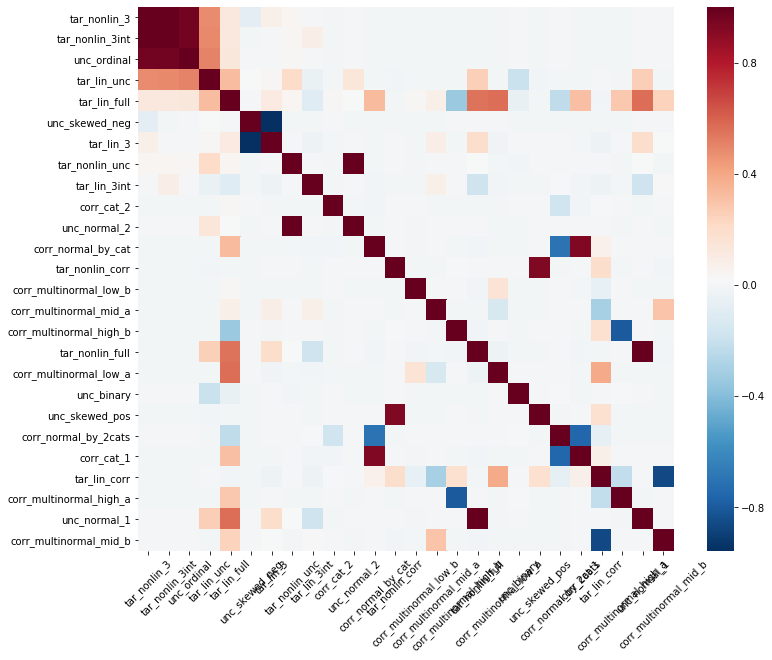

In [127]:
exp.plot_correlations(data, target='tar_nonlin_3')

                        unc_ordinal  unc_normal_1  corr_normal_by_cat  \
unc_ordinal                1.000000      0.001583           -0.004531   
unc_normal_1               0.001583      1.000000            0.001915   
corr_normal_by_cat        -0.004531      0.001915            1.000000   
corr_multinormal_mid_a    -0.004648      0.001232            0.006279   
tar_nonlin_3               0.965494      0.001677           -0.004434   

                        corr_multinormal_mid_a  tar_nonlin_3  
unc_ordinal                          -0.004648      0.965494  
unc_normal_1                          0.001232      0.001677  
corr_normal_by_cat                    0.006279     -0.004434  
corr_multinormal_mid_a                1.000000     -0.003848  
tar_nonlin_3                         -0.003848      1.000000  


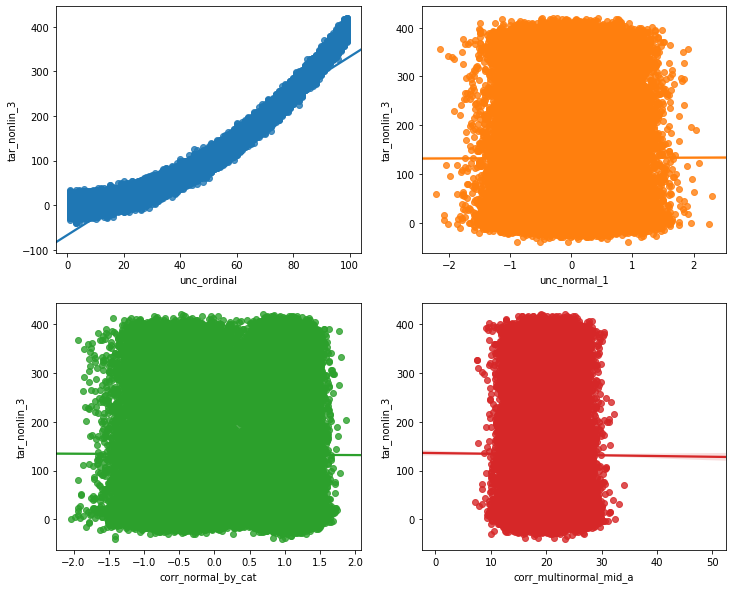

In [128]:
exp.corr_target(data, 'tar_nonlin_3', ['unc_ordinal', 'unc_normal_1', 'corr_normal_by_cat', 'corr_multinormal_mid_a'])

Again, an amazing accidental correlation and very weird patterns for the 3 generating features

In [129]:
coefs_nonlinear['tar_nonlin_3int']

,feat,coef
0,unc_normal_1_squared,0.04
1,corr_normal_by_cat,-0.09
2,corr_multinormal_mid_a_tanh,0.80
3,unc_normal_1__corr_normal_by_cat,0.60
4,all_3,-0.30


tar_nonlin_3int            1.000000
tar_nonlin_3               0.992937
unc_ordinal                0.965511
tar_lin_unc                0.489146
tar_lin_full               0.124907
tar_lin_3int               0.084746
tar_nonlin_unc             0.038275
corr_cat_2                -0.005357
unc_normal_2               0.004939
tar_nonlin_corr           -0.004830
corr_normal_by_cat        -0.004681
corr_multinormal_low_b    -0.004555
corr_multinormal_mid_a    -0.003991
unc_skewed_pos            -0.003704
corr_cat_1                -0.003548
corr_normal_by_2cats       0.003446
corr_multinormal_high_b   -0.003365
tar_nonlin_full           -0.003265
corr_multinormal_low_a    -0.003207
unc_binary                 0.003047
tar_lin_corr              -0.002933
corr_multinormal_high_a   -0.002549
unc_normal_1               0.002050
unc_skewed_neg            -0.001863
corr_multinormal_mid_b     0.001607
tar_lin_3                  0.001285
Name: tar_nonlin_3int, dtype: float64

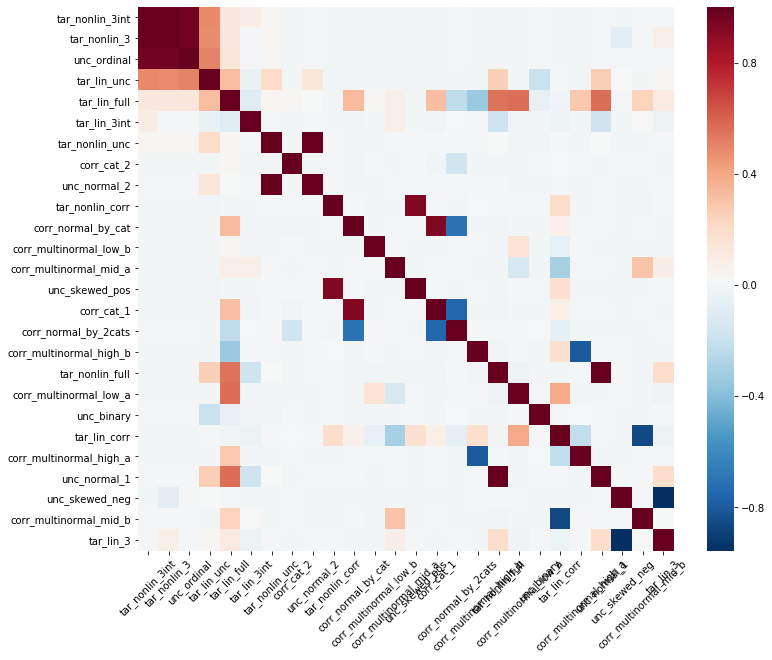

In [130]:
exp.plot_correlations(data, target='tar_nonlin_3int')

                        unc_ordinal  unc_normal_1  corr_normal_by_cat  \
unc_ordinal                1.000000      0.001583           -0.004531   
unc_normal_1               0.001583      1.000000            0.001915   
corr_normal_by_cat        -0.004531      0.001915            1.000000   
corr_multinormal_mid_a    -0.004648      0.001232            0.006279   
tar_nonlin_3int            0.965511      0.002050           -0.004681   

                        corr_multinormal_mid_a  tar_nonlin_3int  
unc_ordinal                          -0.004648         0.965511  
unc_normal_1                          0.001232         0.002050  
corr_normal_by_cat                    0.006279        -0.004681  
corr_multinormal_mid_a                1.000000        -0.003991  
tar_nonlin_3int                      -0.003991         1.000000  


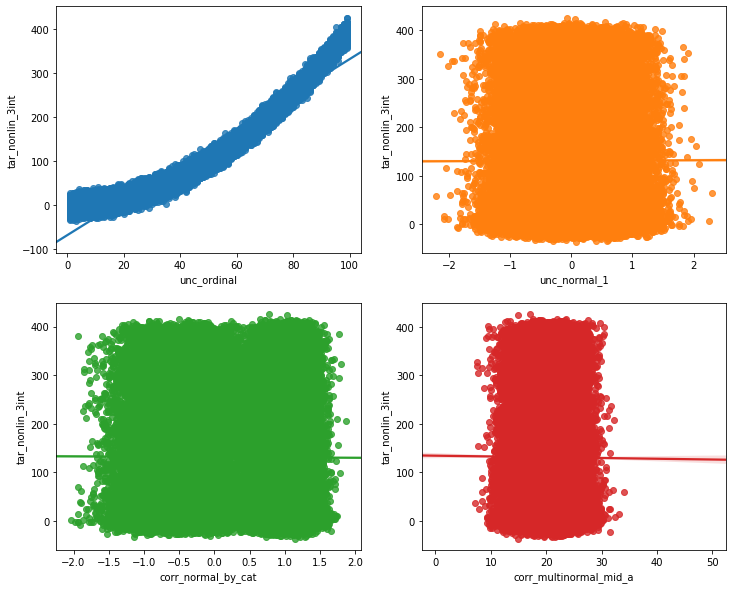

In [131]:
exp.corr_target(data, 'tar_nonlin_3int', ['unc_ordinal', 'unc_normal_1', 'corr_normal_by_cat', 'corr_multinormal_mid_a'])

This time, the weird correlation doesn't disappear. I can't wait to test some models with it.

The main lesson, however, is that we should use this kind of eda as a guide but not rely on it too much as it can mislead us in building models that do not make particular sense. We will explore this aspect in later kernels and move on with the experiment design.


## Dirty data and correlations

Let's see if by using the dirtified version of our data we see something different.

                        unc_skewed_neg  unc_normal_1  corr_normal_by_cat  \
unc_skewed_neg                1.000000      0.000551            0.001350   
unc_normal_1                  0.000551      1.000000            0.001476   
corr_normal_by_cat            0.001350      0.001476            1.000000   
corr_multinormal_mid_a       -0.002140      0.001173            0.006726   
tar_lin_3                    -0.513035      0.195057           -0.001477   

                        corr_multinormal_mid_a  tar_lin_3  
unc_skewed_neg                       -0.002140  -0.513035  
unc_normal_1                          0.001173   0.195057  
corr_normal_by_cat                    0.006726  -0.001477  
corr_multinormal_mid_a                1.000000   0.088152  
tar_lin_3                             0.088152   1.000000  


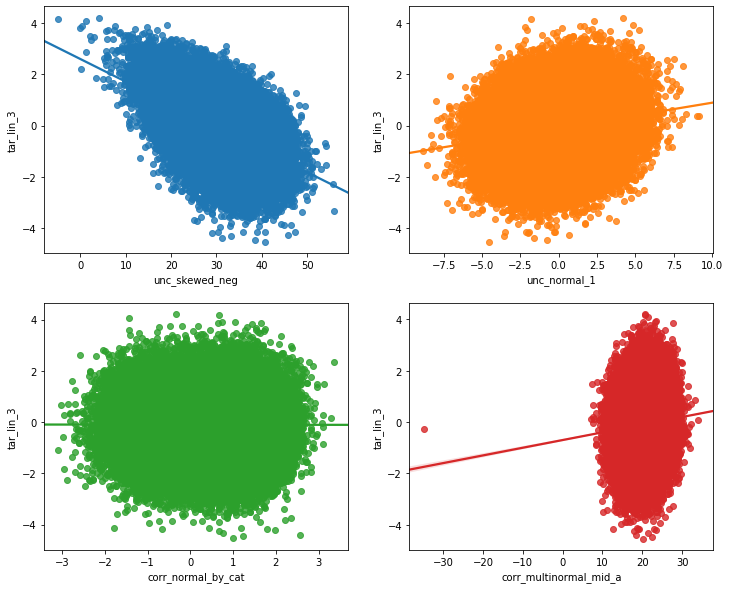

In [133]:
exp.corr_target(data_dirty, 'tar_lin_3', ['unc_skewed_neg', 'unc_normal_1', 'corr_normal_by_cat', 'corr_multinormal_mid_a'])

It appears it does, although the strong correlation remains.